# Final Project

The final project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness and performance of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Your submission should include all outputs and be *self-contained*, so it can be executed if necessary.

The submission includes two parts:
1. this notebook
2. a 15-min presentation, to be held on May 8


## Submission
The project is due on ***May 07, 23:59 CET*** (counted as the time stamp when it is received). Late submissions will **not** be considered, and graded as 0! 

To submit, please:

1. copy this file and all additional data into a folder with your group ID
3. zip the folder
4. send a copy of the zip file to Dirk Hovy <dirk.hovy@unibocconi.it> and Tommaso Fornaciari <fornaciari@unibocconi.it>

## 1. Data, Preprocessing, and Annotation (4 pts)

Find a data set for text classification and a data set for structured prediction. These can be the same.
Kaggle is a good place to start, or the Google data set search. 

The data sets should have **at least 5,000** documents each. **At least 2000 instances** need to be labeled. If there is no label provided, you can annotate your own. You can get up to **3 bonus points** for annotation, depending on the amount and complexity of the annotation.

Split the data into dedicated training, development, and test sets (if they do not include these already)!

**MISSING**
Briefly (max. 100 words!) describe the content and type of the data set, and what you are planning to look at.

**MISSING** Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

**about the statistics before and after preprocessing we can reuse the ones from one of us of the previous assignment**

In [11]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from gensim.models import Doc2Vec, LdaMulticore, TfidfModel, CoherenceModel
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf

from tensorflow import keras
from collections import Counter

from sklearn.metrics import classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from gensim.sklearn_api import D2VTransformer

from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import InputLayer
from keras.models import Model
from keras.layers import Input, Embedding
from keras.layers import Bidirectional, LSTM, Flatten
from keras.layers import Dropout, Dense, Activation

from keras.models import Model
from keras.layers import Input
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers import GlobalMaxPooling1D, Dropout
from keras.layers.core import Dense, Activation

import nltk
from sklearn.preprocessing import OneHotEncoder
import pickle

In [66]:
data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


### FROM WHICH NEWSPAPER IRONY COMES FROM

All the ironic headlines come from Theonion

Presence of NAN: False
                             count
newspaper      is_sarcastic       
huffingtonpost 0             14985
theonion       1             13634


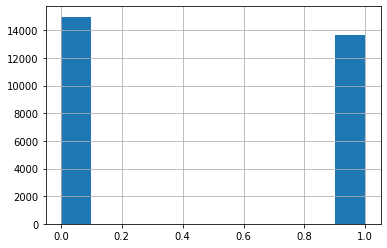

In [67]:
import re
def search_newspaper(x):
    y = re.findall(r"huffingtonpost",x) or re.findall(r"theonion",x)
    return y[0]
    
data['newspaper'] = data['article_link'].apply(search_newspaper)
print('Presence of NAN:', data['newspaper'].isna().any())

print(data.groupby(['newspaper','is_sarcastic'])[['headline']].count().rename({'headline':'count'},axis = 1))

## drop newspaper column
data.drop(columns = 'newspaper',axis = 1, inplace = True)

## The target variable is pretty balanced so looking at accuracy makes total sense
data.is_sarcastic.hist()

In [50]:
nlp = spacy.load('en_core_web_sm')

def preprocessing(sentence, entity_rec = False, POS_tagging_prep = True):
    """
    Input: A document
    Output: A cleaned, tokenised document
    """
    s_list = []
    # POS_tagging and preprocessing 
    if POS_tagging_prep == True:
         return ' '.join([token.lemma_ for token in nlp(sentence) if (token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'} and (token.lemma_.lower() != '’s') 
                                                                  and (token.is_stop == False) and (token.is_punct == False) 
                                                                  and (token.like_url == False))])
                
    # Tokenisation / stop-word removal / punctuation removal / url removal
    else:
        spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
        if entity_rec == True:
            s_analysed = nlp(sentence)
            # Entity recognition
            entity = [entity.text for entity in s_analysed.ents]
            for words in entity:
                modified_words = words.replace(" ", "_")
                sentence = sentence.replace(words, modified_words)        
        s_analysed = nlp(sentence.replace("’s", "")) # removal of ’s before tokenisation 
        for token in s_analysed:
            if (token.is_stop == False) and (token.is_punct == False) and (token.like_url == False):
                s_list.append(token.lemma_.lower())
    return s_list

def verb(text):
    '''
    return the strings with the verbs only
    '''
    return ' '.join([token.lemma_ 
             for token in nlp(text) 
             if token.pos_ in {'VERB'}])

def ADJ(text):
    '''
    return the strings with the adjectives only
    '''
    return ' '.join([token.lemma_ 
             for token in nlp(text) 
             if token.pos_ in {'ADJ'}])

In [51]:
data['cleaned'] = data.headline.apply(preprocessing, entity_rec = True)
data['verb'] = data.headline.apply(verb)
data['adj'] = data.headline.apply(ADJ)
data.drop("article_link", axis = 1, inplace = True)

data['Set'] = np.random.choice(
    ['train', 'valid', 'test'],
    data.shape[0],
    p=[0.7, 0.15, 0.15]
)

In [54]:
# data.to_csv('cleaned_data_2.csv')

### Import cleaned data

In [12]:
data = pd.read_csv("cleaned_data_2.csv")
data.drop('Unnamed: 0',axis = 1,inplace = True)
data.cleaned.dropna(axis = 0,inplace= True)

In [13]:
no_verb = data[["headline","cleaned","Set","is_sarcastic"]].dropna()

In [14]:
data.head()

,is_sarcastic,headline,cleaned,verb,adj,Set
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientist hair loss,NaN,NaN,train
1,0,dem rep. totally nails why congress is falling...,totally nail fall short gender racial equality,nail fall,short racial,train
2,0,eat your veggies: 9 deliciously different recipes,eat veggie deliciously different recipe,eat,different,train
3,1,inclement weather prevents liar from getting t...,inclement weather prevent liar get work,prevent get work,inclement,valid
4,1,mother comes pretty close to using word 'strea...,mother come pretty close word streaming correctly,come use,NaN,test


### Comparison BEFORE and AFTER preprocessing

In [15]:
## SOME STATISTICS
## headline tokens 
headline_tokens = [headline.split() for headline in list(data.headline)]

# Number of tokens
all_headline_tokens = [inner for outer in headline_tokens for inner in outer]
num_headline_tokens = len(all_headline_tokens)
# Number of types
num_headline_types = len(set(all_headline_tokens))

## cleaned headline tokens
cleaned_tokens = [headline.split() for headline in list(data.cleaned)]
# Number of tokens
all_cleaned_tokens = [inner for outer in cleaned_tokens for inner in outer]
num_cleaned_tokens = len(all_cleaned_tokens)
# Number of types
num_cleaned_types = len(set(all_cleaned_tokens))

number_documents = [0 for i in range(2)]
number_types = [0 for i in range(2)]
number_tokens = [0 for i in range(2)]
number_documents[0] = len(headline_tokens)
number_documents[1] = len(cleaned_tokens)
number_types[0] = num_headline_types
number_types[1] = num_cleaned_types
number_tokens[0] = num_headline_tokens
number_tokens[1] = num_cleaned_tokens

## PREPROCESSING SUMMMARY
Preprocessing_Statistics = pd.DataFrame(data = [number_documents,number_types,number_tokens], index = ['Documents', 'Types', 'Tokens'], columns = ['Before Preprocessing', 'After Preprocessing'])
Preprocessing_Statistics

,Before Preprocessing,After Preprocessing
Documents,28619,28455
Types,38234,14817
Tokens,287620,148735


### Additional analysis

In [16]:
def length(sentence):
    tokens = nltk.word_tokenize(sentence)
    return len(tokens)

def avg_word_length(sentence):
    words = nltk.word_tokenize(sentence)
    avg = sum([len(word) for word in words])/len(words)
    return avg

def question_mark(sentence):
    return sentence.count('?')

def exclamation(sentence):
    return sentence.count('!')

In [17]:
no_verb['sentence_length'] = no_verb.headline.apply(length)
no_verb['avg_word_length'] = no_verb.headline.apply(avg_word_length)
no_verb['exclamation'] = no_verb.headline.apply(exclamation)
no_verb['question_mark'] = no_verb.headline.apply(question_mark)

In [18]:
sarcasm = no_verb.loc[no_verb["is_sarcastic"] == 1,["headline","cleaned"]]
normal = no_verb.loc[no_verb["is_sarcastic"] == 0,["headline","cleaned"]]

In [19]:
X_train = no_verb.loc[no_verb.Set =='train', ["cleaned"]]
y_train = no_verb.loc[no_verb.Set =='train', ["is_sarcastic"]]

X_valid = no_verb.loc[no_verb.Set =='valid', ["cleaned"]]
y_valid = no_verb.loc[no_verb.Set =='valid', ["is_sarcastic"]]

X_test = no_verb.loc[no_verb.Set =='test', ["cleaned"]]
y_test = no_verb.loc[no_verb.Set =='test', ["is_sarcastic"]]

In [20]:
no_verb.head()

,headline,cleaned,Set,is_sarcastic,sentence_length,avg_word_length,exclamation,question_mark
0,thirtysomething scientists unveil doomsday clo...,thirtysomething scientist hair loss,train,1,8,6.750000,0,0
1,dem rep. totally nails why congress is falling...,totally nail fall short gender racial equality,train,0,14,4.785714,0,0
2,eat your veggies: 9 deliciously different recipes,eat veggie deliciously different recipe,train,0,8,5.375000,0,0
3,inclement weather prevents liar from getting t...,inclement weather prevent liar get work,valid,1,8,5.625000,0,0
4,mother comes pretty close to using word 'strea...,mother come pretty close word streaming correctly,test,1,10,5.300000,0,0


## 2. Research Question(s) (2 pts)

Describe what question you are investigating with the data (max. 100 words)

### **Report: Amazon Using Heat-Sensing Alien Hunters To Track Workers Attempting To Unionize**

#### **Now, is this a sarcastic headline or not? We are interested in developing an algorithm that is able to detect sarcasm. While this remains an active research area and is considered one of the toughest challenges in NLP (https://link.springer.com/article/10.1007/s10462-019-09791-8?shared-article-renderer), we are confident in tackling this issue by examining the underlying topics, document embeddings and developing a language model. On this basis, we develop a prediction machine.**

## 3. Analysis (6 pts)

Apply at least one version of *each* of the following analysis methods to the data set (justify your choices):
1. Topic modeling with LDA (3 pts). Justify your choice of number of topics!
2. Dense word embeddings ***or*** document embeddings: visualize these and show a clustering (3 pts) 

Your analysis needs to be run on the training data only! You can use the dev set for tuning.

### Other methods
If appropriate for your problem, feel free to explore other methods, as long as they do not require additional libraries (**up to 2 bonus points**).

In [98]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, #df stands for document frequency
                             max_df=0.6, 
                             stop_words='english')
X = tfidf_vectorizer.fit_transform(sarcasm.cleaned.dropna().tolist())

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', min_df=0.01, max_df=0.6, stop_words='english')

X2 = vectorizer.fit_transform(sarcasm.cleaned.dropna().tolist())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
print("Sarcasm Words")
df = df.sort_values(['tfidf', 'tf', 'idf'])
df.tail()

Sarcasm Words


,word,tf,idf,tfidf
18,nation,385,4.569496,308.890973
37,woman,466,4.388481,360.380507
24,report,573,4.166645,455.597051
19,new,753,3.905490,615.215899
17,man,1001,3.612780,743.379542


In [99]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, 
                             max_df=0.6, 
                             stop_words='english')
X = tfidf_vectorizer.fit_transform(normal.cleaned.dropna().tolist()) #I use the title to get the topic
vectorizer = CountVectorizer(analyzer='word', min_df=0.01, max_df=0.6, stop_words='english')

X2 = vectorizer.fit_transform(normal.cleaned.dropna().tolist())

df = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                       })
print("Normal")
df = df.sort_values(['tfidf', 'tf', 'idf'])
df.tail()

Normal


,word,tf,idf,tfidf
14,man,314,4.860292,256.871140
21,say,395,4.630145,344.223808
31,woman,473,4.473098,389.389017
16,new,477,4.447400,400.367527
25,trump,498,4.397906,432.726904


# **Language Model**

In [100]:
from collections import defaultdict
import numpy as np
import nltk


smoothing = 0.001
counts = defaultdict(lambda: defaultdict(lambda: smoothing))
sarcasm["headline"] = sarcasm["headline"].astype(str)
corpus = [line.strip().split() for line in sarcasm.headline.tolist()]

#collect and count
for sentence in corpus:
    #include start and stop in the sentence
    tokens = ['*', '*','*','*','*'] + sentence + ['STOP']
    for u, v, w, x, y, z in nltk.ngrams(tokens, 6): #we create the ngrams from the sentence and we count them
        counts[u, v, w, x, y][z] += 1

def logP(u, v, w):
    #(u,v,w) => P(w) preceeded by u,v we compute the log proba. to avoid numbers that are too small to divivde byand get infinty
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

def sentence_logP(S):
    #score a sentence in log likelihood with chain rule (product becomes sum with log) S: lits of strings
    tokens = ['*', '*'] + S + ['STOP']
    return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])
    #for each sentence we eaxtract the trigrams and we compute their proba, and then sum it so we get the log likelihood

In [101]:
def sample_next_word(u, v, w, x, y):
    #sample a word v based on the history (u,v)
    keys, values = zip(*counts[(u, v, w, x, y)].items()) #items returns a litsof tuples keys and values
    #zip takes any number of arguments and zips them together 
    values = np.array(values)
    values /= values.sum() # create probability distro
    sample = np.random.multinomial(1, values) # pick one position (returns a position)
    return keys[np.argmax(sample)]

def generate2(initial=[]):
    result = ['*', '*','*','*','*'] + initial
    next_word = sample_next_word(result[-5], result[-4], result[-3],result[-2], result[-1])
    result.append(next_word)
    while next_word != 'STOP':
        next_word = sample_next_word(result[-5], result[-4], result[-3],result[-2], result[-1])
        result.append(next_word)

    return ' '.join(result[2:-1])
    return result

In [102]:
print(generate2(['john']))

* * * john kerry sits in shadows of kiev café awaiting woman known only as dasha


In [103]:
print(generate2(['john']))

* * * john kerry throws vine over pit of quicksand to save child companion


In [104]:
print(generate2(['john']))

* * * john boehner to paul ryan: 'i was once young and beautiful too'


In [105]:
print(generate2(['politicians']))

* * * politicians ignoring the dangers of jowl implants


In [106]:
print(generate2([]))

* * * 5-year-old at underfunded kindergarten enjoying last few weeks before achievement gap kicks in


In [107]:
#checking if the generated headlines is in the training data
print(sarcasm["headline"].str.contains("universe feels zero connection to guy tripping on mushrooms").any())
print(sarcasm["headline"].str.contains("politicians ignoring the dangers of jowl implants").any())
print(sarcasm["headline"].str.contains("john bolton insists iran likely harboring dangerous terrorist osama bin laden").any())
print(sarcasm["headline"].str.contains("john edwards pays $30 to register edwards2016.com just in case").any())

True
True
True
False


### Trying with 2grams because with 6grams its too specific and the language model just spits out headlines from the training data. Try increase to 3/4

In [108]:
from collections import defaultdict
import numpy as np
import nltk



for sentence in corpus:
    tokens = ['*', '*'] + sentence + ['STOP']
    for u, v, w in nltk.ngrams(tokens, 3):
        counts[(u, v)][w] += 1

def logP(u, v, w):
    return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

def sentence_logP(S):
    tokens = ['*', '*'] + S + ['STOP']
    return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])

In [109]:
def sample_next_word(u, v):
    keys, values = zip(*counts[(u, v)].items())
    values = np.array(values)
    values /= values.sum() # create probability distro
    sample = np.random.multinomial(1, values) # pick one position
    return keys[np.argmax(sample)]

def generate():
    result = ['*', '*']
    next_word = sample_next_word(result[-2], result[-1])
    result.append(next_word)
    while next_word != 'STOP':
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)

    return ' '.join(result[2:-1])

In [110]:
generate()

'fox voluntarily removes reality from programming'

In [111]:
generate()

'female director asked if this was a setup all along'

In [112]:
generate()

'spacecraft travel from all sides'

In [113]:
generate()

'man putting huge amount of water waste nationwide caused by undetected carbon monoxide detector somewhere'

In [114]:
generate()

'vacationer checks weather report for hometown'

In [115]:
print(sarcasm["headline"].str.contains("dog can't believe he left consulate").any())
print(sarcasm["headline"].str.contains("deceased souls backed up at tall building thinking about, you know").any())
print(sarcasm["headline"].str.contains("sighing trump sexual assault has cooled down").any())
print(sarcasm["headline"].str.contains("matt lauer returns to stage for humans").any())

False
False
False
False


# **LDA topic model**
### COMPARE WITH SVD AND NMF

In [116]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing


# get dictionary
instances = sarcasm.cleaned.dropna().apply(str.split)
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.3) #we restrict ousrlef with words that occur more than 50 times, and words that occur below 30% of the documents. 
print(dictionary, flush=True)

creating dictionary
Dictionary(74 unique tokens: ['get', 'work', 'come', 'run', 'area']...)


In [117]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] #replace each words by its id in our vocabulary, list of list of integers
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


## **Choosing number of topics**

In [16]:
import random

coherence_values = []
model_list = []

dev_size = 5000
eval_size = 1000

random.seed(42)
for num_topics in range(4, 10):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         workers=min(10, multiprocessing.cpu_count()-1),
                         num_topics=num_topics)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    umass_score = coherencemodel_umass.get_coherence()
    coherence_values.append((num_topics, umass_score))
    
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass'])

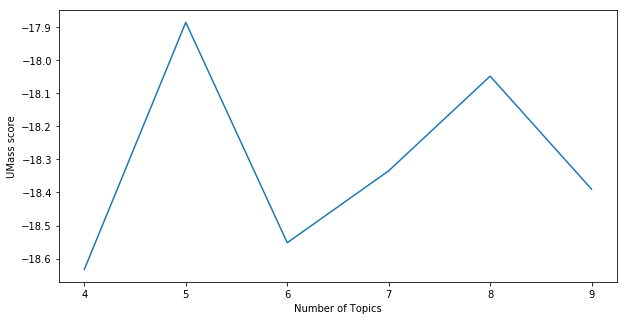

In [17]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(scores.num_topics, scores.UMass)
plt.xlabel('Number of Topics')
plt.ylabel('UMass score')
plt.show()

#### **Best score reached for 5 topics**

In [119]:
num_topics = 5

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5 #controls how many topics we expcet to see in a document. if alpha is big we expect to see all topics in one document, large alpha is 100
                    )
    
print("done in {}".format(time.time()-start), flush=True)

679.75
fitting model
done in 9.201999187469482


In [120]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

print("Sarcasm Topics")
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

Sarcasm Topics
1 "report", "woman", "area", "trump", "look"
2 "nation", "find", "go", "good", "study"
3 "man", "year", "family", "friend", "think"
4 "new", "day", "old", "life", "announce"
5 "time", "get", "child", "work", "come"


## Non sarcasm LDA

In [121]:
# get dictionary
# run on 50000 instances
instances = normal.cleaned.dropna().apply(str.split)
print("creating dictionary", flush=True)
# read in instances and create Dictionary object w information about frequencies etc. 
dictionary = Dictionary(instances)
# get rid of words that are too rare or too frequent
dictionary.filter_extremes(no_below=100, no_above=0.3) #we restrict ousrlef with words that occur more than 50 times, and words that occur below 30% of the documents. 
print(dictionary, flush=True)

creating dictionary
Dictionary(85 unique tokens: ['way', 'know', 'parent', 'tell', 'leave']...)


In [ ]:
import random

coherence_values = []
model_list = []

dev_size = 5000
eval_size = 1000

random.seed(42)
for num_topics in range(4, 10):
    model = LdaMulticore(corpus=model_corpus[:dev_size], 
                         id2word=dictionary, 
                         workers=min(10, multiprocessing.cpu_count()-1),
                         num_topics=num_topics)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=instances[dev_size:dev_size+eval_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    umass_score = coherencemodel_umass.get_coherence()
    coherence_values.append((num_topics, umass_score))
    
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass'])

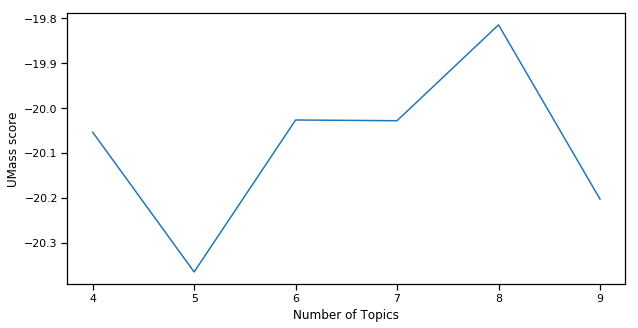

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(scores.num_topics, scores.UMass)
plt.xlabel('Number of Topics')
plt.ylabel('UMass score')
plt.show()

In [123]:
#replace words by their numerical IDs and their frequency
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances] #replace each words by its id in our vocabulary, list of list of integers
# learn TFIDF values from corpus
print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)
# transform raw frequencies into TFIDF
model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [124]:
num_topics = 8

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5 #controls how many topics we expcet to see in a document. if alpha is big we expect to see all topics in one document, large alpha is 100
                    )
    
print("done in {}".format(time.time()-start), flush=True)

743.0
fitting model
done in 11.611222505569458


In [125]:
import re

# get the topic descritions
topic_sep = re.compile(r"0\.[0-9]{3}\*") # getting rid of useless formatting
# extract a list of tuples with topic number and descriptors from the model
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

print("NOrmal headlines Topics")
descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

NOrmal headlines Topics
1 "time", "look", "make", "win", "health"
2 "attack", "talk", "old", "come", "police"
3 "year", "man", "thing", "want", "watch"
4 "trump", "day", "good", "need", "know"
5 "woman", "black", "call", "help", "go"
6 "new", "get", "find", "world", "bad"
7 "say", "way", "life", "change", "right"
8 "love", "people", "kid", "take", "big"


### **Result : sarcasm doesn't differentiate itself by the topic**

## Document embedding

In [88]:
d2v_model = D2VTransformer(size=100, min_count=1, workers=6)
d2v_data = d2v_model.fit_transform(data.cleaned.apply(str.split).tolist())

In [89]:
tsne_d2v = TSNE(n_components=2, verbose = 1, random_state = 42).fit_transform(d2v_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 28455 samples in 0.276s...
[t-SNE] Computed neighbors for 28455 samples in 83.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28455
[t-SNE] Computed conditional probabilities for sample 2000 / 28455
[t-SNE] Computed conditional probabilities for sample 3000 / 28455
[t-SNE] Computed conditional probabilities for sample 4000 / 28455
[t-SNE] Computed conditional probabilities for sample 5000 / 28455
[t-SNE] Computed conditional probabilities for sample 6000 / 28455
[t-SNE] Computed conditional probabilities for sample 7000 / 28455
[t-SNE] Computed conditional probabilities for sample 8000 / 28455
[t-SNE] Computed conditional probabilities for sample 9000 / 28455
[t-SNE] Computed conditional probabilities for sample 10000 / 28455
[t-SNE] Computed conditional probabilities for sample 11000 / 28455
[t-SNE] Computed conditional probabilities for sample 12000 / 28455
[t-SNE] Computed conditional probabilities for sa

In [94]:
tfidf = TfidfVectorizer(analyzer='word', 
                             min_df=0.01, 
                             max_df=0.75, 
                             stop_words='english')
vector_sample  = tfidf.fit_transform(data.cleaned.tolist())
svd = TruncatedSVD(n_components=2)
low_dim_svd = TruncatedSVD(n_components=2)
low_dim_U = low_dim_svd.fit_transform(vector_sample)

svd_data = pd.DataFrame(low_dim_U, columns = ['x','y'])
svd_data['label'] = data.is_sarcastic.replace({0 : 'Normal', 1 : 'Sarcastic'})

Text(0.5, 1.0, 'T-SNE Decomposition')

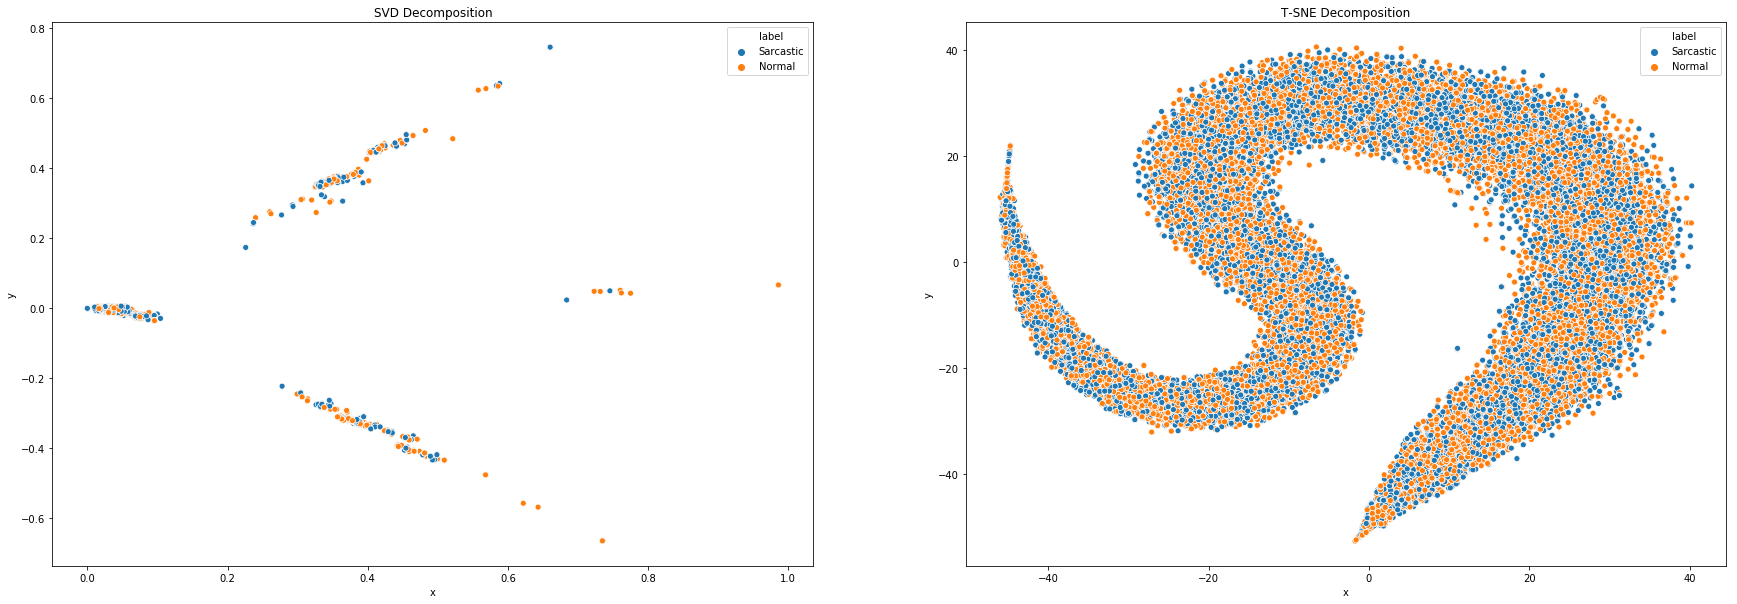

In [95]:
tsne_d2v_df = pd.DataFrame(data=tsne_d2v, columns=["x", "y"])
tsne_d2v_df['label'] = data.is_sarcastic.replace({0 : 'Normal', 1 : 'Sarcastic'})

plt.figure(figsize = (30, 10))
ax = plt.subplot(1,2,1)
seaborn.scatterplot('x', 'y', data=svd_data, hue='label', ax=ax)
ax.set_title('SVD Decomposition')
ax = plt.subplot(1,2,2)
seaborn.scatterplot('x', 'y', data=tsne_d2v_df, hue='label',ax=ax)
ax.set_title('T-SNE Decomposition')

### This looks really cool, and it shows that it's not trivial to differentiate between the two groups

### CLUSTERING PART

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb

sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('afmhot') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)] #we discretisize the color gradient to labels components
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

CPU times: user 13.3 s, sys: 767 ms, total: 14.1 s
Wall time: 2.36 s
CPU times: user 8.1 s, sys: 156 ms, total: 8.25 s
Wall time: 7.32 s


/home/hugopao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  """Entry point for launching an IPython kernel.


CPU times: user 1.27 s, sys: 68 ms, total: 1.34 s
Wall time: 523 ms


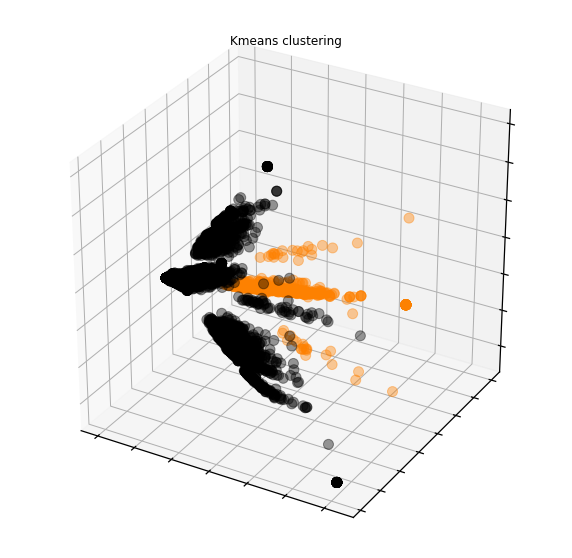

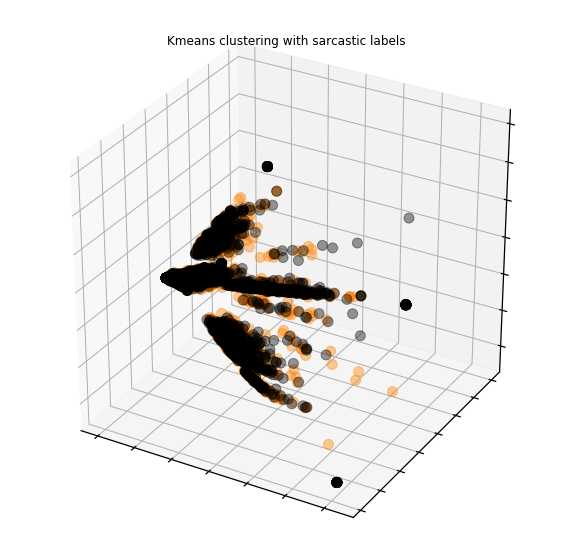

In [19]:
from sklearn.cluster import KMeans, AgglomerativeClustering

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   stop_words='english', 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.7, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(data.cleaned.tolist())


k = 2

# reduce the dimensionality of the input, to speed up clustering
%time X2 = TruncatedSVD(n_components=300).fit_transform(X)

agg = AgglomerativeClustering(n_clusters=k)
sample = np.random.choice(len(X2), replace=False, size=8000)
%time agg_sample_ids = agg.fit_predict(X2[sample])
centroids = np.array([X2[sample][agg_sample_ids == c].mean(axis=0) for c in range(k)])
km = KMeans(n_clusters=k, 
            n_jobs=-1, 
            init=centroids)

# fit it on the full 300-dimensional data set
%time km.fit(X2)

plot_vectors(X2, title = 'Kmeans clustering',labels=km.labels_)
plot_vectors(X2, title = 'Kmeans clustering with sarcastic labels',labels = data.is_sarcastic)

### Sentence Length and Average word length

In [60]:
list_sarcasm = no_verb[no_verb["is_sarcastic"] == 1]['sentence_length'].to_list()
list_normal = no_verb[no_verb["is_sarcastic"] == 0]['sentence_length'].to_list()

from scipy.stats import ttest_ind

print(ttest_ind(list_sarcasm, list_normal))
print("p_value is 1% the sentence length is the same")

Ttest_indResult(statistic=2.384577821712274, pvalue=0.017105241792974006)
p_value is 1% the sentence length is the same


In [61]:
list_sarcasm = no_verb[no_verb["is_sarcastic"] == 1]['avg_word_length'].to_list()
list_normal = no_verb[no_verb["is_sarcastic"] == 0]['avg_word_length'].to_list()

from scipy.stats import ttest_ind

print(ttest_ind(list_sarcasm, list_normal))
print("p_value is 0% the avg_word_length length is the same")

Ttest_indResult(statistic=40.98539829209385, pvalue=0.0)
p_value is 0% the avg_word_length length is the same


In [62]:
list_sarcasm = no_verb[no_verb["is_sarcastic"] == 1]['exclamation'].to_list()
list_normal = no_verb[no_verb["is_sarcastic"] == 0]['exclamation'].to_list()

from scipy.stats import ttest_ind

print(ttest_ind(list_sarcasm, list_normal))
print("p_value is 0% the number of exclamation length is the same")

Ttest_indResult(statistic=-7.9320860087451415, pvalue=2.2335583795112354e-15)
p_value is 0% the number of exclamation length is the same


In [63]:
list_sarcasm = no_verb[no_verb["is_sarcastic"] == 1]['question_mark'].to_list()
list_normal = no_verb[no_verb["is_sarcastic"] == 0]['question_mark'].to_list()

from scipy.stats import ttest_ind

print(ttest_ind(list_sarcasm, list_normal))
print("p_value is 0% the number of question_mark length is the same")

Ttest_indResult(statistic=-20.37120239833513, pvalue=1.357719813453224e-91)
p_value is 0% the number of question_mark length is the same


# add sumarized version of all the models AND ADD SMALL DESCRIPTION OF THE REASONING.

## 4. Prediction (15 pts)


### 4.1 Classification (9 pts)
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline (1 point)
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features (1 pt)
3. the performance of **at least** two more predictive model architecture (2 pts each), including description/justification of the optmization steps taken (2 pts).
4. two bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines (1 pts)

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!

#### 4.1.1. Most-Frequent-Label baseline
The Dummy Classifier gives a measure of baseline performance since it returns a sort of success rate one should expect by simply guessing: in this case it considers the most frequent label in the headlines which is "not sarcastic".

In [22]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

X_dev = no_verb.loc[no_verb.Set =='valid', ["cleaned"]]
y_dev =no_verb.loc[no_verb.Set =='valid', ["is_sarcastic"]]

most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)
dumb_predictions = most_frequent.predict(X_test)

print(classification_report(y_test, dumb_predictions))

              precision    recall  f1-score   support

           0       0.52      1.00      0.68      2223
           1       0.00      0.00      0.00      2061

    accuracy                           0.52      4284
   macro avg       0.26      0.50      0.34      4284
weighted avg       0.27      0.52      0.35      4284



#### 4.1.2. Logistic-Regression baseline
In classification problems the logistic regression results a good measure of baseline performance since it is a simple generalized linear model that runs quickly and gives a first look at the accuracy improvement gap: our purpose is to beat this baseline, if possible.

In [160]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(2,6), 
                             analyzer='char')

X_train = no_verb.loc[no_verb.Set =='train', ["cleaned"]]
X_valid = no_verb.loc[no_verb.Set =='valid', ["cleaned"]]
X_test = no_verb.loc[no_verb.Set =='test', ["cleaned"]]

X_train = vectorizer.fit_transform(X_train.cleaned.tolist())
X_valid = vectorizer.transform(X_valid.cleaned.tolist())
X_test = vectorizer.transform(X_test.cleaned.tolist())

In [26]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(n_jobs=-1, multi_class='auto', solver = 'lbfgs')
%time classifier.fit(X_train, y_train.values.ravel())
print(classifier)

CPU times: user 67.6 ms, sys: 140 ms, total: 207 ms
Wall time: 5.91 s
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [27]:
predictions = classifier.predict(X_test)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76      2223
           1       0.74      0.72      0.73      2061

    accuracy                           0.74      4284
   macro avg       0.74      0.74      0.74      4284
weighted avg       0.74      0.74      0.74      4284



Logistic-Regression adding the balanced option to treat the sarcastic and not sarcastic headlines with the same importance.

In [28]:
classifier_balanced = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                         class_weight='balanced')
%time classifier_balanced.fit(X_train, y_train.values.ravel())
predictions_balanced = classifier_balanced.predict(X_test)

print(classification_report(y_test, predictions_balanced))

CPU times: user 22.6 ms, sys: 39.3 ms, total: 61.9 ms
Wall time: 3.76 s
              precision    recall  f1-score   support

           0       0.76      0.74      0.75      2223
           1       0.73      0.74      0.73      2061

    accuracy                           0.74      4284
   macro avg       0.74      0.74      0.74      4284
weighted avg       0.74      0.74      0.74      4284



#### 4.1.3.1. Naive Bayes Classifier
We implement Naive Bayes Classifier because in practise it works pretty well; moreover, it is easy to implement, fast on huge amout of data and parallelizes well.

In [163]:
from sklearn import model_selection, naive_bayes, svm
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(X_train,y_train.values.ravel())
# predict the labels on validation dataset
predictions_NB = Naive.predict(X_valid)
# Use classification_report function to get the accuracy
print(classification_report(y_valid, predictions_NB))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2313
           1       0.71      0.71      0.71      1988

    accuracy                           0.73      4301
   macro avg       0.73      0.73      0.73      4301
weighted avg       0.73      0.73      0.73      4301



#### 4.1.3.2. Support Vector Machines
SVM is another algorithm that usually in classification problem performs well: the main problem is that if the amount of data is big, it is very slow because it can not be parallelized.

In [165]:
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel = 'linear', gamma='auto')
SVM.fit(X_train,y_train.values.ravel())
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test)
print(classification_report(y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76      2223
           1       0.74      0.74      0.74      2061

    accuracy                           0.75      4284
   macro avg       0.75      0.75      0.75      4284
weighted avg       0.75      0.75      0.75      4284



#### 4.1.3.3. XGBoost Classifier
XGBoost has been chosen because it is a decision-tree ensemble machine learning model that uses an optimized gradient boosting framework which often outperforms all other algorithms.

First we have run with default parameters to see how it generally performs:

In [152]:
import xgboost
clf = xgboost.XGBClassifier(n_estimators = 1000, n_jobs = 4)
clf.fit(X_train, y_train.values.ravel())
predictions_boost = clf.predict(X_valid)
print(classification_report(y_valid, predictions_boost))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2313
           1       0.72      0.66      0.69      1988

    accuracy                           0.73      4301
   macro avg       0.73      0.72      0.72      4301
weighted avg       0.73      0.73      0.73      4301



Then we have tuned the parameters with GridSearchCV. The result is not printed because, due to the huge computational demand, it has been run on GCP and still with few parameters. The results are:
- 'learning_rates' = 0.001
- 'max_depth' = 3
- 'min_child_weight' = 1

In [ ]:
## XGBOOST TUNING PARAMETERS
#clf = xgboost.XGBClassifier(n_estimators = 1000, n_jobs = 16)

#print("fitting grid search")
#params = {
#         'min_child_weight': [1, 5, 10],
#         'max_depth': [3, 4, 5],
#         'learning_rates' : [0.001, 0.01, 0.1]
#         }

#grid_search = GridSearchCV(clf, params, cv = 5, scoring = "accuracy", n_jobs = 16)
#grid_search.fit(X_train,y_train)
#print(grid_search.best_params_)

The tuning of the parameters didn't improve the performance:

In [155]:
clf = xgboost.XGBClassifier(n_estimators = 1000, learning_rates = 0.001, max_depth = 3, min_child_weight =1, n_jobs = 4, verbose = 1)
clf.fit(X_train, y_train.values.ravel())
predictions_boost = clf.predict(X_test)
print(classification_report(y_test, predictions_boost))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2223
           1       0.74      0.65      0.70      2061

    accuracy                           0.72      4284
   macro avg       0.73      0.72      0.72      4284
weighted avg       0.73      0.72      0.72      4284



#### 4.1.3.4. Sequential API ??

In [162]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential

model = Sequential()
model.add(Dense(128, input_dim = X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 1
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data = (X_valid, y_valid))

Train on 19870 samples, validate on 4301 samples
Epoch 1/1
19870/19870 [==============================] - 347s 17ms/step - loss: 0.5623 - accuracy: 0.7028 - val_loss: 0.5022 - val_accuracy: 0.7484


In [16]:
predictions_deep = (model.predict(X_test)>0.5)
print(classification_report(y_test, predictions_deep))

              precision    recall  f1-score   support

           0       0.73      0.79      0.76      2239
           1       0.76      0.68      0.72      2097

    accuracy                           0.74      4336
   macro avg       0.74      0.74      0.74      4336
weighted avg       0.74      0.74      0.74      4336



#### 4.1.3.5. Bi-LSTM
Recurrent Neural Nets can be used not only for language modeling and multi-class text classification but also for binary classification: taking into account the usual performance of this algorithm, we have decided to implement Bi-LSTM to predict the labels of the headlines.

In [29]:
X_train = no_verb.loc[no_verb.Set =='train', ["cleaned"]]
y_train = no_verb.loc[no_verb.Set =='train', ["is_sarcastic"]]

X_valid = no_verb.loc[no_verb.Set =='valid', ["cleaned"]]
y_valid = no_verb.loc[no_verb.Set =='valid', ["is_sarcastic"]]

X_test = no_verb.loc[no_verb.Set =='test', ["cleaned"]]
y_test = no_verb.loc[no_verb.Set =='test', ["is_sarcastic"]]

##### 4.1.3.5.1. Preparing the dataset

In [88]:
# collect known word tokens and tags
wordset = set()
train_instances = [words for words in X_train.cleaned.apply(str.split)]
for words in train_instances:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words

def convert2ints(instances):
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        result.append(word_ints)
    return result 

In [89]:
# get some test data
test_instances = [words for words in X_test.cleaned.apply(str.split)]

# apply integer mapping
train_instances_int = convert2ints(train_instances)
test_instances_int = convert2ints(test_instances)

In [90]:
# get some valid data
valid_instances = [words for words in X_valid.cleaned.apply(str.split)]

# apply integer mapping
valid_instance_int = convert2ints(valid_instances)

In [91]:
MAX_LENGTH = int(np.percentile([len(instance) for instance in train_instances_int],95))
MAX_LENGTH

9

In [92]:
# add special padding at the end of every instance, up to MAX_LENGTH
train_sentences = pad_sequences(train_instances_int, maxlen=MAX_LENGTH, padding='post')
test_sentences = pad_sequences(test_instances_int, maxlen=MAX_LENGTH, padding='post')
valid_sentences = pad_sequences(valid_instance_int, maxlen=MAX_LENGTH, padding='post')
print(train_sentences[0])

[11378  9821  5071  6569     0     0     0     0     0]


##### 4.1.3.5.2.  Implementing the model
The Bidirectional-LSTM layer has been set up to 128 memory units and since it is a classification problem we use a Dense output layer with a single neuron and a sigmoid function to predict 0 or 1. As optimizer we choose RMSprop from keras.optimizers but also "adam" works well in this situation.

In [157]:
np.random.seed(42)
from keras.optimizers import RMSprop
model_seq = Sequential()
model_seq.add(InputLayer(input_shape=(MAX_LENGTH, ), name="word_IDs"))
model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
model_seq.add(Bidirectional(LSTM(128), name='bi-LSTM'))
#model_seq.add(LSTM(64))
model_seq.add(Dense(256, name = 'fully_connected1', activation = 'relu'))
model_seq.add(Dropout(0.2, name='dropout'))
model_seq.add(Dense(1, activation = 'sigmoid', name='output'))
model_seq.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (Embedding)       (None, 9, 128)            1629440   
_________________________________________________________________
bi-LSTM (Bidirectional)      (None, 256)               263168    
_________________________________________________________________
fully_connected1 (Dense)     (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 257       
Total params: 1,958,657
Trainable params: 1,958,657
Non-trainable params: 0
_________________________________________________________________


In [151]:
batch_size = 32
epochs = 2

import keras
# compile the model we have defined above
model_seq.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model_seq.fit(train_sentences, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (valid_sentences, y_valid))

/Users/SimoneSilvestri/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19870 samples, validate on 4301 samples
Epoch 1/2
19870/19870 [==============================] - 21s 1ms/step - loss: 0.5416 - accuracy: 0.7204 - val_loss: 0.4891 - val_accuracy: 0.7724
Epoch 2/2
19870/19870 [==============================] - 23s 1ms/step - loss: 0.4139 - accuracy: 0.8124 - val_loss: 0.4755 - val_accuracy: 0.7761


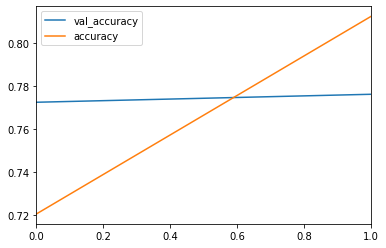

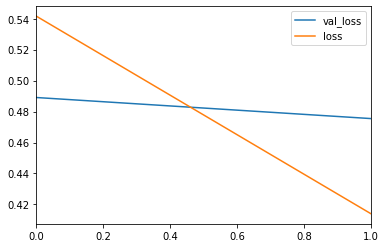

In [155]:
df = pd.DataFrame(history.history)
df[['val_accuracy', 'accuracy']].plot.line()
df[['val_loss', 'loss']].plot.line()

In [153]:
loss, accuracy = model_seq.evaluate(test_sentences, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

#this was achieved with one epoch

4284/4284 [==============================] - 1s 153us/step
Test loss: 0.485087031409854
Test accuracy: 0.7670401334762573


In [154]:
predictions_LSTM = (model_seq.predict(test_sentences)>0.5)
print(classification_report(y_test, predictions_LSTM))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2223
           1       0.77      0.74      0.75      2061

    accuracy                           0.77      4284
   macro avg       0.77      0.77      0.77      4284
weighted avg       0.77      0.77      0.77      4284



#### 4.1.3.6. CNN
Convolutional Neural Nets is perfectly in line with our purpose since we need a way to take an arbitrarily long sequence of words as input (headlines) and produce an output (sarcastic or not sarcastic).

In [114]:
np.random.seed(42)

# set parameters of matrices and convolution
embedding_dim = 128
nb_filter = 64
filter_length = 3
hidden_dims = 128


inputs = Input((MAX_LENGTH, ), 
               name='word_IDs')
embeddings = Embedding(len(word2int), 
                       embedding_dim, 
                       input_length=MAX_LENGTH)(inputs)
convolution = Conv1D(filters=nb_filter,  # Number of filters to use
                    kernel_size=filter_length, # n-gram range of each filter.
                    padding='same',  #valid: don't go off edge; same: use padding before applying filter
                    activation='relu',
                    strides=1)(embeddings)
convolution2 = Activation(activation='tanh')(convolution)
pooling = GlobalMaxPooling1D()(convolution2)
dropout1 = Dropout(0.2)(pooling)
dense = Dense(32, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense)
output = Dense(1, activation='sigmoid')(dropout2)

model = Model(inputs=[inputs], outputs=[output])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_IDs (InputLayer)        (None, 9)                 0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 9, 128)            1629440   
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 9, 64)             49216     
_________________________________________________________________
activation_12 (Activation)   (None, 9, 64)             0         
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 64)                0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 32)                208

In [115]:
batch_size = 32
epochs = 5
CUDA_VISIBLE_DEVICES=""
import keras
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
# compile the model we have defined above
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy']
             )

# run training and capture ouput log
history = model.fit(train_sentences, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data = (valid_sentences, y_valid))

/Users/SimoneSilvestri/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 19870 samples, validate on 4301 samples
Epoch 1/5
19870/19870 [==============================] - 7s 374us/step - loss: 0.6763 - accuracy: 0.5849 - val_loss: 0.6548 - val_accuracy: 0.6373
Epoch 2/5
19870/19870 [==============================] - 7s 359us/step - loss: 0.6030 - accuracy: 0.6951 - val_loss: 0.5586 - val_accuracy: 0.7224
Epoch 3/5
19870/19870 [==============================] - 7s 353us/step - loss: 0.4702 - accuracy: 0.7914 - val_loss: 0.5033 - val_accuracy: 0.7570
Epoch 4/5
19870/19870 [==============================] - 8s 385us/step - loss: 0.3728 - accuracy: 0.8460 - val_loss: 0.5020 - val_accuracy: 0.7640
Epoch 5/5
19870/19870 [==============================] - 8s 413us/step - loss: 0.3072 - accuracy: 0.8783 - val_loss: 0.5252 - val_accuracy: 0.7584


In [116]:
loss, accuracy = model.evaluate(test_sentences, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

4284/4284 [==============================] - 0s 25us/step
Test loss: 0.5373534429974917
Test accuracy: 0.7542017102241516


In [117]:
predictions_CNN = (model.predict(test_sentences)>0.5)
print(classification_report(y_test, predictions_CNN))

              precision    recall  f1-score   support

           0       0.77      0.75      0.76      2223
           1       0.74      0.76      0.75      2061

    accuracy                           0.75      4284
   macro avg       0.75      0.75      0.75      4284
weighted avg       0.75      0.75      0.75      4284



### 4.2 Structured Prediction (6pts)
Run the Structured Prediction model as-is on your sequence prediction task, and note the performance as baseline (1 pt).
Change the features to improve performance (2 pts).
Run a suitable neural net implementation (in `keras`) on the data and compare the best performance to the other two models (4 pts).

In [11]:
corpus = [line.split() for line in sarcasm.headline.tolist()]

X_train = []
y_train = []
for sentence in corpus[:2000]:
    #include start and stop in the sentence
    tokens =  sentence 
    for i in range (len(tokens)-1) :
        X = tokens[:i]
        y = tokens[i+1]
        X_train.append(X)
        y_train.append(y)

y_train = np.array(y_train)
X_train = np.array(X_train)

In [12]:
vocab_size = len(np.unique(y_train))

one_hot = OneHotEncoder()
y_train_one_hot = one_hot.fit_transform(y_train.reshape(-1, 1))


wordset = set()
for words in X_train:
    wordset.update(set(words))

# map words and tags into ints
PAD = '-PAD-'
UNK = '-UNK-'
word2int = {word: i + 2 for i, word in enumerate(sorted(wordset))}
word2int[PAD] = 0  # special token for padding
word2int[UNK] = 1  # special token for unknown words

In [13]:
def convert2ints(instances):
    result = []
    for words in instances:
        # replace words with int, 1 for unknown words
        word_ints = [word2int.get(word, 1) for word in words]
        # replace tags with int
        result.append(word_ints)
    return result 

def convert2int(text):
    result = []
    # replace words with int, 1 for unknown words
    word_ints = [word2int.get(word, 1) for word in text]
    # replace tags with int
    result.append(word_ints)
    return result


train_instances_int = convert2ints(X_train)
# test_instances_int = convert2ints(test_instances)

train_sentences = pad_sequences(train_instances_int, maxlen=9, padding='post')
print(train_sentences[5])


#np.random.seed(42)
#from keras.optimizers import RMSprop
#model_seq = Sequential()
#model_seq.add(InputLayer(input_shape=(9, ), name="word_IDs"))
##model_seq.add(Embedding(len(word2int), 128, mask_zero=True, name='embeddings'))
#model_seq.add(Bidirectional(LSTM(units=256, return_sequences=False), name="Bi-LSTM"))
#model_seq.add(Dense(256, name = 'fully_connected1', activation = 'relu'))
#model_seq.add(Dropout(0.2, name='dropout'))
#model_seq.add(Dense(vocab_size, activation = 'softmax', name='output'))
#model_seq.summary()

batch_size = 32
epochs = 45

#model_seq.compile(loss='binary_crossentropy',
 #             optimizer=RMSprop(),
  #            metrics=['accuracy']
   #          )
#history = model_seq.fit(train_sentences, y_train_one_hot,
 #                   batch_size=batch_size,
  #                  epochs=epochs,
   #                 verbose=1,
    #                )

[5588 4855 5850 1847 1251    0    0    0    0]


In [14]:
filename = 'BiLSTM_language_model.sav'
model_seq = pickle.load(open(filename, 'rb'))

/home/hugopao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hugopao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [16]:
def generate(text):
    liste = convert2int(text)
    train_sentences = pad_sequences(liste, maxlen=9, padding='post')
    a = np.random.choice(np.array([a for a in range(vocab_size)]), size = 1, p = np.transpose(model_seq.predict(train_sentences)[0]))
    return np.unique(y_train)[a[0]]


def run(text, sentence_length):
    texte = [text]
    for i in range (sentence_length):
        t = generate(texte)
        texte.append(t)
    print(' '.join(texte))


filename = 'BiLSTM_language_model.sav'
model_seq = pickle.load(open(filename, 'rb'))
run("", 5)

/home/hugopao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/hugopao/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


 on many house nightly back


## Significance Testing

In [38]:
def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [44]:
p_value, deltas = bootstrap_sample(predictions_CNN, predictions_LSTM, y_test)
print(p_value, p_value < 0.01)

0.024 False


In [45]:
p_value, deltas = bootstrap_sample(predictions_CNN, predictions, y_test) #between the hulk and CNN
print(p_value, p_value < 0.01)

0.021 False


In [55]:
p_value, deltas = bootstrap_sample(predictions_LSTM, predictions, y_test)
print(p_value, p_value < 0.01)

0.443 False


In [56]:
p_value, deltas = bootstrap_sample(predictions, dumb_predictions,y_test)
print(p_value, p_value < 0.01)

0.0 True


In [57]:
p_value, deltas = bootstrap_sample(predictions_LSTM, dumb_predictions, y_test)
print(p_value, p_value < 0.01)

0.0 True


### Logreg vs dummy baseline, try to stack all the good models add the summary here.
### Performances are not statistically different

# Performance sum up

,Dummy,Hulk,Xgboost,FF Neural Net,LSTM,CNN
Accuracy,0.52,0.76,0.73,0.59,0.77,0.76


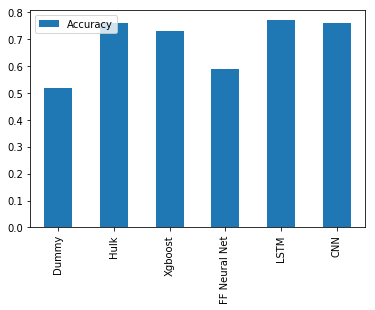

In [12]:
d = {"Dummy" :0.52, "Hulk" : 0.76, "Xgboost" : 0.73, 'FF Neural Net' : 0.59, 'LSTM':0.77, 'CNN':0.76}
dataframe = pd.DataFrame(data = d, index =["Accuracy"])
result = dataframe.transpose()
result.plot.bar()
dataframe

In [51]:
column = [ predictions_CNN, predictions_deep, predictions_boost,predictions, dumb_predictions, predictions_balanced]
data = []

p_value, deltas = bootstrap_sample(predictions_LSTM, predictions, y_test)
print(p_value, p_value < 0.01)

0.449 False


In [ ]:
df

## 3. Visualizations (3 pts)

Provide at least 3 visualizations of your work above. These can be in the respective sections. Use labels and legends. Be creative. Just please do not use word clouds...

In [357]:
# your code here
def pos(text):
    return ' '.join([token.pos_ for token in nlp(text)])

# Add new column with parts of speech of each review
data['review_pos'] = data.cleaned.apply(pos)

In [360]:
pos_sarcasm = data.loc[data.is_sarcastic == 1, ["review_pos"]]
pos_normal = data.loc[data.is_sarcastic == 0, ["review_pos"]]

In [383]:
pos_sarcasm = pos_sarcasm.astype(str)
pos_normal = pos_normal.astype(str)

In [384]:
# Here I want to find out whether we can see a difference in the relative amount of nouns, verbs, adjectives, etc. used, 
# i.e. analysing their relative frequency, in positive and negative reviews. 

# Reset the indices of the distinct positive and negative review dataframes
pos_sarcasm.reset_index(drop=True, inplace = True)
pos_normal.reset_index(drop=True, inplace = True)

# Sarcastic - make list of dictionaries for fraction of times the type of word appears in review
dict_list = []
for i in range(pos_sarcasm.shape[0]):
    temp_list = pos_sarcasm.review_pos[i].split()
    temp_dict = dict(Counter(temp_list))
    for j in temp_dict:
        temp_dict[j] = temp_dict[j] / len(temp_list)
    dict_list.append(temp_dict)

# Make lists for how often each word type appears across the different reviews
relevant_word_types = ['VERB','ADV', 'ADJ', 'PROPN', 'NOUN', 'PRON']
word_type_frequencies_pos = {k: [] for k in relevant_word_types}


for word_type in relevant_word_types:
    for i in range(len(dict_list)):
        if word_type in dict_list[i]:
            word_type_frequencies_pos[word_type].append(dict_list[i][word_type])


# Normal - make list of dictionaries for fraction of times the type of word appears in review
dict_list = []
for i in range(pos_normal.shape[0]):
    temp_list = pos_normal.review_pos[i].split()
    temp_dict = dict(Counter(temp_list))
    for j in temp_dict:
        temp_dict[j] = temp_dict[j] / len(temp_list)
    dict_list.append(temp_dict)
    
# Make lists for how often each word type appears across the different reviews
relevant_word_types = ['VERB','ADV', 'ADJ', 'PROPN', 'NOUN', 'PRON']
word_type_frequencies_neg = {k: [] for k in relevant_word_types}


for word_type in relevant_word_types:
    for i in range(len(dict_list)):
        if word_type in dict_list[i]:
            word_type_frequencies_neg[word_type].append(dict_list[i][word_type])

## identical lines

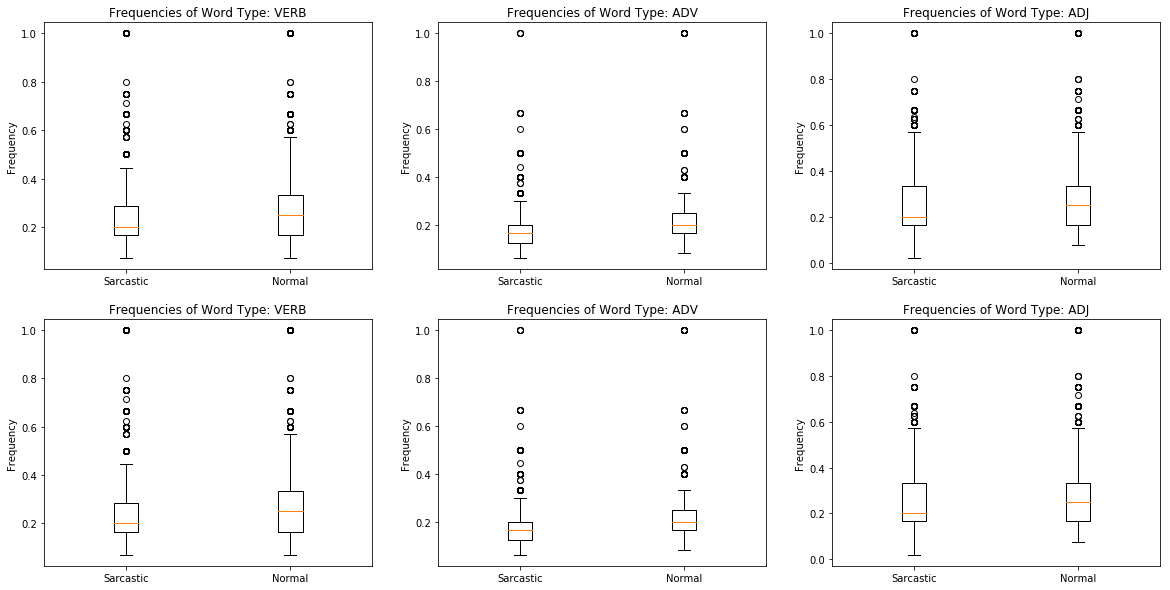

In [415]:
fig, axs = plt.subplots(2, 3)
fig.set_figheight(10)
fig.set_figwidth(20)
for i, word in zip([0,1,2],relevant_word_types):
    for j in range(2):
        axs[j][i].boxplot([word_type_frequencies_pos[word], word_type_frequencies_neg[word]])
        axs[j][i].set_title('Frequencies of Word Type: %s' %word)
        axs[j][i].set_ylabel('Frequency')
        axs[j][i].set_xticklabels(['Sarcastic', 'Normal'])

# clustering viz(3D)
# shap values graph

# **BONUS : HOW SARCASTIC IS THE NEW YORK TIMES ?**

In [9]:
nyt = pd.read_csv("nyt_data.csv")
headlines = nyt.the_headline
headlines.head()

0    What’s on TV Tuesday: ‘Carmen Sandiego’ and ‘I...
1                                   Banana Republicans
2       The Tokyo 2020 Olympics: What You Need to Know
3              The Impeachment Dilemma for Republicans
4    Protests Erupt in Hong Kong, Overshadowing Chi...
Name: the_headline, dtype: object

In [12]:
headlines = headlines.apply(preprocessing)

In [ ]:
headlines.shape

In [13]:
#applying same transfo
nyt_vectorized = vectorizer.transform(headlines.tolist())

In [86]:
# applying the hulk 
np.mean(classifier.predict(nyt_vectorized))

0.11670636270840422

In [88]:
np.mean(clf.predict(nyt_vectorized))

0.1205247438660164